In [2]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import imp
import cantera as ct
imp.reload(rmtchem)
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 16, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})

### Example graph 

57


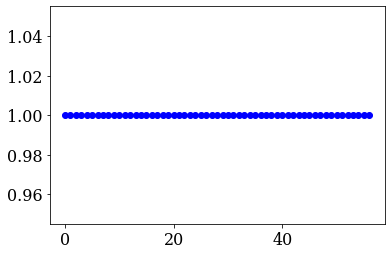

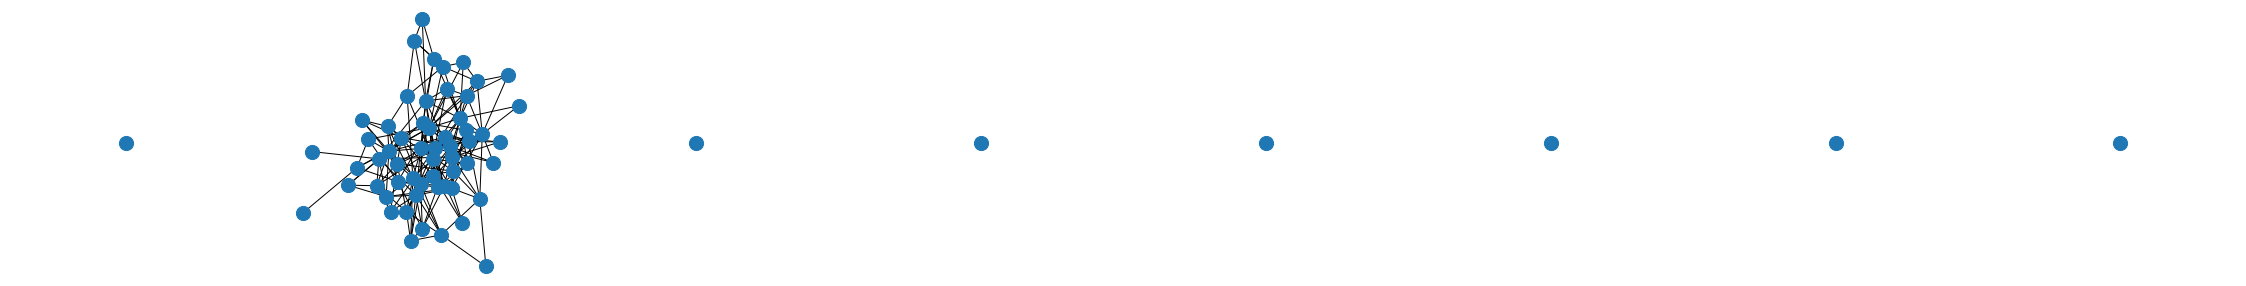

In [2]:
n=64
c=0.5
nr=int(c*n)
seed=1

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr)
adj=np.zeros((n,n))
for r in range(2*nr):
    reac=np.where(eta[r]>0)[0]
    prod=np.where(nu[r]>0)[0]
    for i in reac:
        for j in prod:
            adj[i,j]=1
        #if species are both reactants, they affect rates of change of each other
        for j in reac:
            adj[i,j]=1
g=nx.convert_matrix.from_numpy_matrix(adj)

lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]

print(n)
X0=np.exp(-G)
XD1=np.zeros(n)
XD2=np.zeros(n)
success,Xs2=rmtchem.steady(X0,eta,nu,k,XD1,XD2)
plt.plot(Xs2/X0,'bo')
plt.show()

g=nx.convert_matrix.from_numpy_matrix(adj)
components=list(sorted(nx.connected_components(g)))
if len(components)>1:
    fig, ax = plt.subplots(1,len(components),figsize=(5*len(components),5))
    for i in range(len(components)):
        comp=list(components)[i]
        idx=np.array(list(comp))
        nx.draw(nx.convert_matrix.from_numpy_matrix(adj[np.ix_(idx,idx)]),node_size=200,ax=ax[i])
        ax[i].axis('off')
else:
    nx.draw(g,node_size=200)

plt.savefig('plots/fig1b.pdf')
plt.show()
# Xs,success=rmtchem.integrate(X0,eta,nu,k,XD1,XD2,100,0.1,prog=True)
# plt.plot(Xs)
# plt.show()

### Chemical network percolation

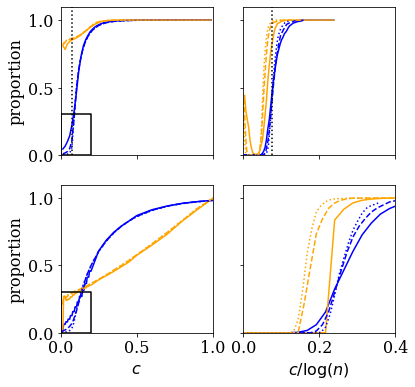

In [202]:
ns=[64,512,4096]
ls=['-','--',':']

plt.subplots(2,2,figsize=(6,6))

plt.subplot(2,2,1)
plt.ylabel("proportion")
plt.ylim(0,1.1)
plt.xlim(0,1)
locs, labels = plt.xticks()
plt.xticks(locs,[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3),dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/(20/3),dat[:,3],color='orange',linestyle=ls[i])
plt.plot([0,0.2,0.2,0,0],[0.3,0.3,0,0,0.3],color='black')
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(2,2,2)
plt.ylim(0,1.1)
plt.xlim(0,0.4)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)

locs, labels = plt.xticks()
plt.xticks(locs,[])
for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3)/np.log(n),dat[:,4],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/(20/3)/np.log(n),dat[:,5],color='orange',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(2,2,3)
plt.xlabel('$c$')
plt.ylabel("proportion")
plt.ylim(0,1.1)
plt.xlim(0,1)
for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1],dat[:,3],color='orange',linestyle=ls[i])
    
plt.plot([0,0.2,0.2,0,0],[0.3,0.3,0,0,0.3],color='black')

plt.subplot(2,2,4)
plt.xlabel('$c/\log(n)$')
plt.xlim(0,0.4)
plt.ylim(0,1.1)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)

for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/np.log(n),dat[:,4],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/np.log(n),dat[:,5],color='orange',linestyle=ls[i])
plt.savefig('plots/fig2.pdf')
plt.show()

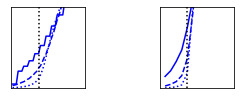

In [5]:
ns=[64,512,4096]
ls=['-','--',':']
fig, axs = plt.subplots(1,2,figsize=(4,1.5))

plt.subplot(1,2,1)
plt.xlim(0,0.2)
plt.ylim(0,0.3)
plt.yticks([],[])
plt.xticks([],[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(1,2,2)
plt.xlim(0,0.2)
plt.ylim(0,0.3)
plt.yticks([],[])
plt.xticks([],[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3),dat[:,2],color='blue',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')
plt.subplots_adjust(wspace=1.0,hspace=0.0)

plt.savefig('plots/fig2insets.pdf')
plt.show()


### Bifurcation examples

0.402900	4030	
Changed too much! decreasing step	40.280000 	0.010000	0.013703	2.588393	0.008516	0.008485	0.000189	-0.001877
0.402950	4032	
Changed too much! decreasing step	40.285000 	0.010000	0.013677	2.577674	0.008531	0.008500	0.001215	-0.000842
0.402900	4033	
Changed too much! decreasing step	40.285000 	0.005000	0.003421	1.288837	0.008516	0.008500	0.000189	-0.000842
0.402900	4035	
Changed too much! decreasing step	40.287500 	0.002500	0.000855	0.643080	0.008516	0.008508	0.000189	-0.000326
0.402900	4037	
Changed too much! decreasing step	40.288750 	0.001250	0.000214	0.321206	0.008516	0.008512	0.000189	-0.000068
0.402894	4038	
Changed too much! decreasing step	40.288750 	0.000625	0.000053	0.160603	0.008514	0.008512	0.000061	-0.000068
0.402894	4040	
Changed too much! decreasing step	40.289063 	0.000313	0.000013	0.080281	0.008514	0.008513	0.000061	-0.000004
0.402892	4041	
Changed too much! decreasing step	40.289063 	0.000156	0.000003	0.040140	0.008513	0.008513	0.000028	-0.000004
0.402891

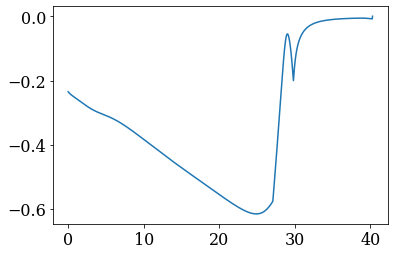

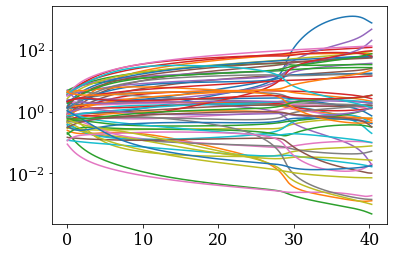

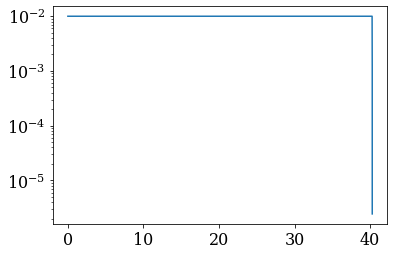

In [1716]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.05*n)
na=0
seed=131
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
steps=10000
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()

Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,(d1max-d1min)/steps,output=True,stop=False)

plt.plot(epsilons,np.max(np.real(evals),axis=1))
plt.show()
plt.yscale('log')
plt.plot(epsilons,Xs)
plt.show()

plt.yscale('log')
plt.plot(epsilons[:-1],np.diff(epsilons))
plt.show()

In [1714]:
#never presents Hopf/1??

-1

In [1702]:
print(np.max(np.real(evals),axis=1)[1280:1300])
print(epsilons[1280:1300])

[-0.15091964 -0.12351751 -0.10790901 -0.09026474 -0.06920266 -0.05633296
 -0.04883943 -0.04016103 -0.03512281  0.03259103  0.03259103 -0.04468733
 -0.05270233 -0.05977178 -0.06618627 -0.07211215 -0.07765526 -0.0828879
 -0.08786206 -0.09261662]
[12.795     12.8       12.8025    12.805     12.8075    12.80875
 12.809375  12.81      12.8103125 12.8103125 12.81      12.8096875
 12.8090625 12.8084375 12.8078125 12.8071875 12.8065625 12.8059375
 12.8053125 12.8046875]


False


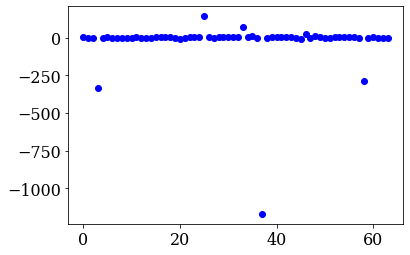

-0.0303497521954052


KeyboardInterrupt: 

In [1412]:
imp.reload(rmtchem)

m=len(Xs)-1
epsilon=epsilons[m]*1.01
np.random.seed(3)
success,solx=rmtchem.steady(Xs[m],eta, nu, k, (1+epsilon)*XD1,XD2)
print(success)
plt.plot(Xs[m]/(solx),'bo')
plt.show()

mat=rmtchem.jac(0,Xs[m],eta, nu, k, (1+epsilon)*XD1,XD2)
ev,evec=np.linalg.eig(mat)
print(np.max(np.real(ev)))

X2,success=rmtchem.integrate(Xs[m]*(1+(0.5-np.random.random(size=n))*1e-2), eta, nu, k, (1+epsilon)*XD1,XD2,1e4,1e0,prog=True)

success,solx=rmtchem.steady(X2[-1],eta, nu, k, (1+epsilon)*XD1,XD2)
print(success)
plt.plot(X2[-1]/(solx),'bo')
plt.show()

mat=rmtchem.jac(0,solx,eta, nu, k, (1+epsilon)*XD1,XD2)
ev,evec=np.linalg.eig(mat)
print(np.max(np.real(ev)))

plt.yscale('log')
plt.plot(X2/Xs[m])
plt.show()

In [1370]:
imp.reload(rmtchem)
X2s,epsilon2s,eval2s,bif=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, epsilon,d1min,(d1max-d1min)/steps,output=True, stop=True)
X3s,epsilon3s,eval3s,bif=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, epsilon,d1max,(d1max-d1min)/steps,output=True, stop=True)

0.154640		
Changed too much! decreasing step 13.201612 	-0.011848	0.587210	3.854871	0.273187	0.381828
0.155019	
Changed too much! decreasing step 13.189764 	-0.005924	0.691386	2.457182	0.176252	0.273187
test5209	

Branch lost! decreasing step 13.183840 -0.002962	

Failed to converge!  13.18383980054037


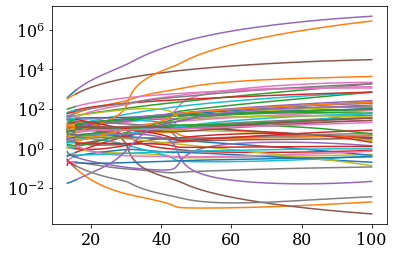

In [1377]:
plt.yscale('log')
plt.plot(epsilon2s,X2s/np.exp(-G))
plt.plot(epsilon3s,X3s/np.exp(-G))
plt.show()

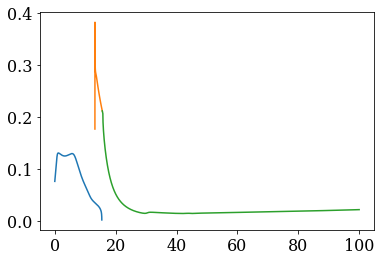

In [1371]:
plt.plot(epsilons,np.min(np.abs(evals),axis=1))
plt.plot(epsilon2s,np.min(np.abs(eval2s),axis=1))
plt.plot(epsilon3s,np.min(np.abs(eval3s),axis=1))

ValueError: could not broadcast input array from shape (19) into shape (3253)

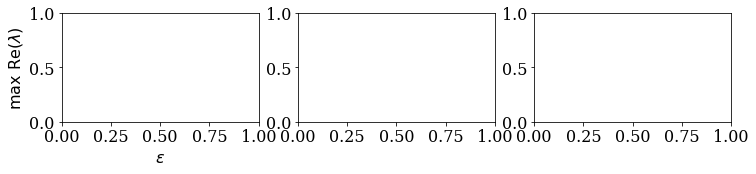

In [565]:
m=len(Xs)-1
m2=len(X2s)-1
plt.subplots(1,3,figsize=(12,2))
plt.subplot(1,3,1)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\mathrm{max}~\mathrm{Re}(\lambda)$')
evals4=np.zeros(steps)
evals5=np.zeros(steps)
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)
evals4[:m+1]=np.max(np.real(evals),axis=1)
evals4[m+1:]=np.max(np.real(evals3),axis=1)
evals5[m+1:]=np.max(np.real(evals3),axis=1)
evals5[m-m2:m+1]=np.flip(np.max(np.real(evals2),axis=1),axis=0)
evals5[:m-m2]=np.max(np.real(evals),axis=1)[:m-m2]
plt.plot(d1s,evals4)
plt.plot(d1s,evals5)

plt.subplot(1,3,2)
lim=1.1*np.max(np.abs(evals[-1,np.argsort(np.real(evals[-1]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.ylabel(r'$\mathrm{Im}(\lambda)$')
plt.xlabel(r'$\mathrm{Re}(\lambda)$')
plt.plot(np.real(evals[-2]),np.imag(evals[-2]),'bo')

plt.subplot(1,3,3)
plt.yscale('log')
plt.ylabel(r"$X_i'/X_i^0$")
plt.xlabel('$\epsilon$')
X4s=np.zeros((steps,n))
X5s=np.zeros((steps,n))
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)
X4s[:m+1]=Xs
X4s[m+1:]=X3s
X5s[m+1:]=X3s
X5s[m-m2:m+1]=np.flip(X2s,axis=0)
X5s[:m-m2]=Xs[:m-m2]
plt.yscale('log')
plt.ylim(0.01,100)
plt.plot(d1s,X5s/X4s)

plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3a.pdf')
plt.show()

In [1546]:
64*0.5*np.log(64)

133.0842586675095

0.376500	
Hopf bifurcation! 37.65000000000108
0.860000	
Branch lost! decreasing step 85.990000 0.010000	
0.859950	
Branch lost! decreasing step 85.990000 0.005000	
0.859950	
Branch lost! decreasing step 85.992500 0.002500	
0.859938	
Changed too much! decreasing step 85.992500 	0.001250	280.972082	334.144182	0.001716	0.079646
0.859931	
Branch lost! decreasing step 85.992500 0.000625	
0.859928	
Changed too much! decreasing step 85.992500 	0.000313	1.508145	83.536045	0.007357	0.079646
0.859927	
Branch lost! decreasing step 85.992500 0.000156	
0.859926	
Branch lost! decreasing step 85.992500 0.000078	
0.859925	
Branch lost! decreasing step 85.992500 0.000039	
0.859925	
Branch lost! decreasing step 85.992500 0.000020	
0.859925	
Branch lost! decreasing step 85.992500 0.000010	
0.859925	
Branch lost! decreasing step 85.992500 0.000005	
0.859925	
Branch lost! decreasing step 85.992500 0.000002	
0.859925	
Branch lost! decreasing step 85.992500 0.000001	
0.859925	
Failed to converge!  85.9925006

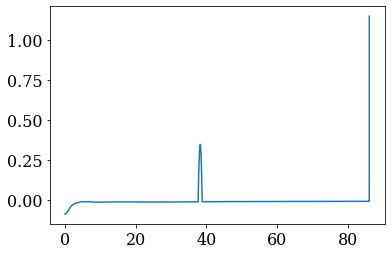

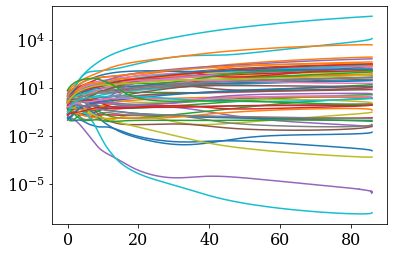

In [1575]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=0
seed=93
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na)

row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]

d0=1e6
d1min=0
d1max=100
steps=10000
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2,d1min,d1max, (d1max-d1min)/steps, output=True,stop=False)
print(len(Xs),bif)
plt.plot(epsilons,np.max(np.real(evals),axis=1))
plt.show()

plt.plot(epsilons,Xs)
plt.yscale('log')
plt.show()

Integration: 100%|##############################################| Time: 0:00:01


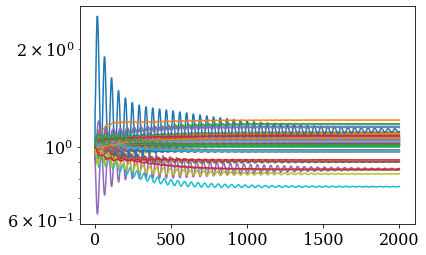

In [1588]:
m=np.where(np.max(np.real(evals),axis=1)>1e-2)[0][0]
epsilon=epsilons[m]*1.05
X2,success=rmtchem.integrate(Xs[m]*(1+(0.5-np.random.random(size=n))*0e-2), eta, nu, k, (1+epsilon)*XD1,XD2,2e0,1e-3,prog=True)
plt.yscale('log')
plt.plot(X2/Xs[m])
plt.show()

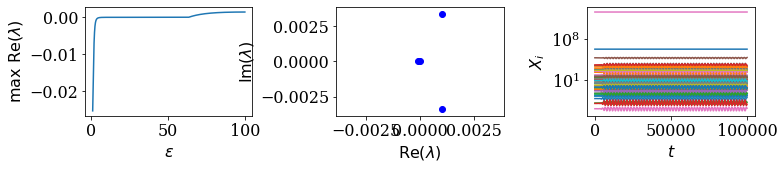

In [99]:
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)

plt.subplots(1,3,figsize=(12,2))
plt.subplot(1,3,1)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\mathrm{max}~\mathrm{Re}(\lambda)$')
plt.plot(d1s,np.max(np.real(evals),axis=1))

plt.subplot(1,3,2)
lim=1.1*np.max(np.abs(evals[m,np.argsort(np.real(evals[m]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
# plt.ylim(-0.1,0.1)
plt.ylabel(r'$\mathrm{Im}(\lambda)$')
plt.xlabel(r'$\mathrm{Re}(\lambda)$')
plt.plot(np.real(evals[m]),np.imag(evals[m]),'bo')

plt.subplot(1,3,3)
plt.yscale('log')
plt.ylabel('$X_i$')
plt.xlabel('$t$')
plt.plot(np.arange(0,1e5,1e1),X2)
plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3b.pdf')
plt.show()

### Bifurcations vs driving and connectivity

(81, 5)


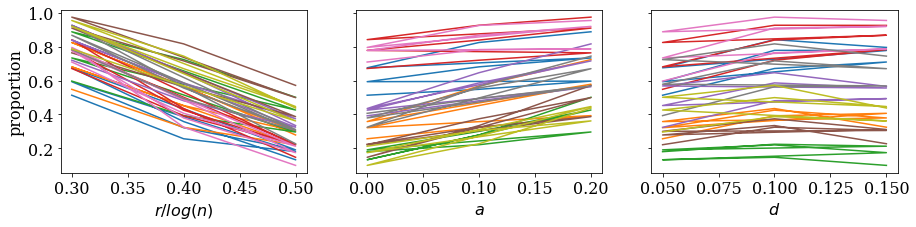

In [7]:
ns=[64,128,256]
cs=[0.3,0.4,0.5]
ds=[0.05,0.1,0.15]
ass=[0,0.1,0.2]
tab=[]
for n in ns:
    for c in cs:
        for d in ds:
            for a in ass:
                vals=np.loadtxt('data/hystereses2/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                tot=np.count_nonzero(vals[:,4]==0)+np.count_nonzero(vals[:,4]==1)+np.count_nonzero(vals[:,4]==2)
                tab.append([c, d, a, np.count_nonzero(vals[:,4]==1)/tot,  np.count_nonzero(vals[:,4]==2)/tot])
                
tab=np.array(tab)
print(tab.shape)
cs=np.unique(tab[:,0])
ds=np.unique(tab[:,1])
ass=np.unique(tab[:,2])

fig,ax=plt.subplots(1,3,figsize=(15,3))
plt.subplot(1,3,1)
plt.xlabel('$r/log(n)$')
plt.ylabel('proportion')
for d in ds:
    for a in ass:
        ind=np.where(np.all(tab[:,[1,2]]==[d,a],axis=1))[0]
        plt.plot(tab[ind,0],tab[ind,4]+tab[ind,3])

plt.subplot(1,3,2)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$a$')
for d in ds:
    for c in cs:
        ind=np.where(np.all(tab[:,[1,0]]==[d,c],axis=1))[0]
        plt.plot(tab[ind,2],tab[ind,4]+tab[ind,3])

plt.subplot(1,3,3)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$d$')
for a in ass:
    for c in cs:
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
        plt.plot(tab[ind,1],tab[ind,4]+tab[ind,3])
plt.savefig('plots/fig4.pdf',transparent=True)
plt.show()

(9, 6)


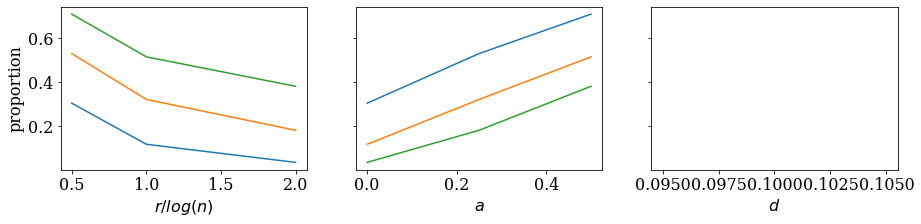

In [1536]:
ns=[64]
cs=[0.5,1.0,2.0]
ds=[0.1]
ass=[0,0.25,0.5]
tab=[]
for n in ns:
    for c in cs:
        for d in ds:
            for a in ass:
                vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                tot=np.count_nonzero(vals[:,4]==0)+np.count_nonzero(vals[:,4]==1)+np.count_nonzero(vals[:,4]==2)
                tab.append([c, d, a, np.count_nonzero(vals[:,4]==1)/tot,  np.count_nonzero(vals[:,4]==2)/tot,np.count_nonzero(vals[:,4]<0)/tot])
                
tab=np.array(tab)
print(tab.shape)
cs=np.unique(tab[:,0])
ds=np.unique(tab[:,1])
ass=np.unique(tab[:,2])

fig,ax=plt.subplots(1,3,figsize=(15,3))
plt.subplot(1,3,1)
plt.xlabel('$r/log(n)$')
plt.ylabel('proportion')
for d in ds:
    for a in ass:
        ind=np.where(np.all(tab[:,[1,2]]==[d,a],axis=1))[0]
        plt.plot(tab[ind,0],tab[ind,4]+tab[ind,3])

plt.subplot(1,3,2)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$a$')
for d in ds:
    for c in cs:
        ind=np.where(np.all(tab[:,[1,0]]==[d,c],axis=1))[0]
        plt.plot(tab[ind,2],tab[ind,4]+tab[ind,3])

plt.subplot(1,3,3)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$d$')
for a in ass:
    for c in cs:
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
        plt.plot(tab[ind,1],tab[ind,4]+tab[ind,3])
plt.savefig('plots/fig4.pdf',transparent=True)
plt.show()

In [97]:
from scipy.stats import ttest_ind,pearsonr

for n in ns:
    for d in ds:
        for c in cs:
            for a in as:
                vals=np.loadtxt('data/hystereses2/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                x=vals[np.where(vals[:,4]==2.)[0],5]
                y=(vals[np.where(vals[:,4]==2.)[0],8]-vals[np.where(vals[:,4]==2.)[0],9])/c
                print(pearsonr(x,y))

(0.007023553559090158, 0.9398295749215291)
(0.05031621681687626, 0.6596683575935252)
(0.4774085427787028, 0.0013885822371962962)
(-0.01021271270369667, 0.9033048204107208)
(-0.0020229801519840163, 0.9846455974059817)
(-0.07887154440665113, 0.538920812984755)
(0.13433772652730494, 0.18494384253712537)
(-0.056084641418866814, 0.6785993008655892)
(-0.12374386963283965, 0.4020580215137715)


### Empirical reaction network stoichiometry

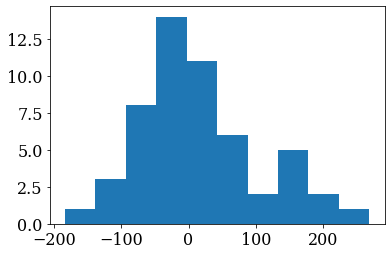

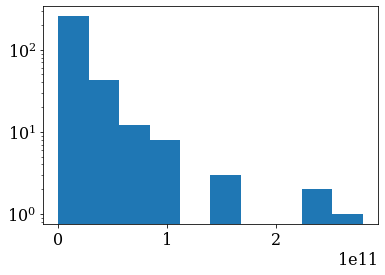

In [7]:
gas=ct.Solution('gri30.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
plt.yscale('log')
plt.hist(gas.forward_rate_constants)
plt.show()

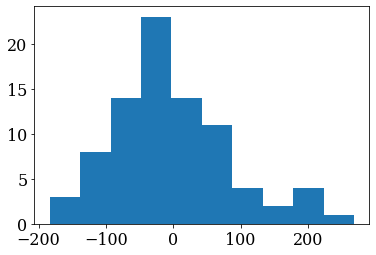

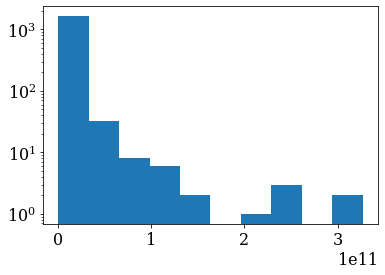

In [8]:
gas=ct.Solution('pyrolysis.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
indices=np.where(gas.forward_rate_constants<1e15)[0]
plt.yscale('log')
plt.hist(gas.forward_rate_constants[indices])
plt.show()

# Generate ODE file for AUTO

In [108]:
imp.reload(rmtchem)

<module 'rmtchem' from '/Users/zack/Documents/rmtchem/rmtchem.py'>

In [1494]:
0.000072/0.000080

0.8999999999999999

In [1592]:
(d1max-d1min)/steps

0.01

0.254500	2546	
Hopf bifurcation! 25.45000000000118
10000 10	10000	


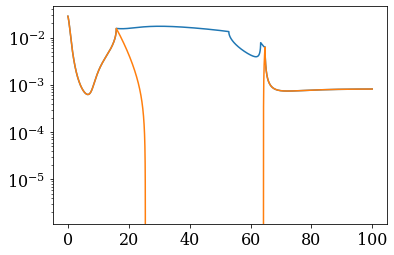

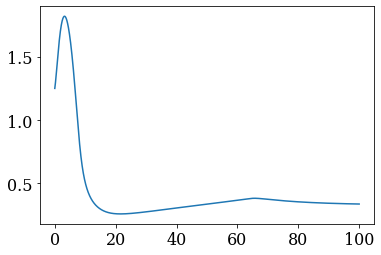

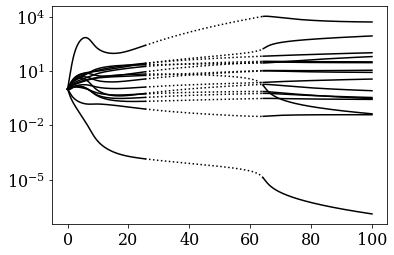

In [1690]:
imp.reload(rmtchem)
n=16
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=0
seed=134
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
steps=10000
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)

r=np.linalg.matrix_rank(adj.toarray()[np.ix_(lcc,lcc)])
if(r==n):

    Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,dep0=1e-2,output=True, stop=False)
    print(len(Xs),bif)

    file=open('rmtchem.ode','w')
    for i in range(n):
        if i in inds:
            print('X[%i]\'=ep*D[%i]-E[%i]*X[%i]'%(i,i,i,i),end='',file=file)
        else:
            print('X[%i]\'=0'%(i),end='',file=file)
        for j in range(2*nr):
            if((eta[j,i]-nu[j,i])!=0):
                print('+(%i)*%f'%(eta[j,i]-nu[j,i],k[j]),end='',file=file)
                inds2=np.where(nu[j]>0)[0]
                for l in inds2:
                    print('*X[%i]^(%i)'%(l,nu[j,l]),end='',file=file)
        print('\n',end='',file=file)

    for i in range(n):
        print('init X[%i]=%f'%(i,np.exp(-G)[i]),file=file)

    print('par ep=1',file=file)
    for i in range(n):
        if i in inds:
            print('par D[%i]=%f'%(i,XD1[i]),file=file)    
            print('par E[%i]=%f'%(i,XD2[i]),file=file)

    print('@ XP=T,YP=X0,XLO=0,XHI=1000,YLO=0,YHI=10',file=file)
    print('@ meth=cvode,dt=0.01,total=1000,nout=1000',file=file)
    print('@ NTST=50, NMAX=1000000, NPR=0, DSMIN=1e-6, DSMAX=1e-2, DS=1e-3, PARMIN=1.0, PARMAX=100',file=file)
    print('@ EPSU=1e-4, EPSL=1e-4, EPSS=1e-4',file=file)
    ind=np.setdiff1d(np.arange(n),inds)[0]
    print('@ NORMMAX=1e10, AUTOXMIN=0.0, AUTOXMAX=%f, AUTOYMIN=0, AUTOYMAX=%f, AUTOVAR=X%i'%(1.5*np.max(epsilons),1.5*np.max(Xs[:,ind]),ind),file=file)
    print('@ runnow=1, bound=100000',file=file)
    print('done',file=file)

    file.close()
    
    plt.yscale('log')
    plt.plot(epsilons,np.min(np.abs(evals),axis=1))
    plt.plot(epsilons,-np.max(np.real(evals),axis=1))
    plt.show()
    plt.plot(epsilons,Xs[:,ind])
    plt.show()
    
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    plt.plot(epsilons[inds],Xs[inds,:]/np.exp(-G),color='black')
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    plt.plot(epsilons[inds],Xs[inds,:]/np.exp(-G),color='black',ls=':')
plt.show()